# Машинное обучение, ФЭН ВШЭ

# Практическое задание 3

## Общая информация

Дата выдачи: 29.10.2017

Срок сдачи: 23:59MSK 05.11.2017

### О задании

Практическое задание 5 посвящено использованию ядер в методах машинного обучения. В рамках данного задания вы:
 * исследуете вид разделяющих поверхностей в исходном пространстве в зависимости от типа используемов ядра и значений его параметров
 * используете SVD для сжатия картинок
 * исследуете обычный и ядровый PCA

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW3_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW3_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

## SVM

**1. (0.5 баллов)** Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно разделимыми классами;
- с хорошо разделимыми классами, но не линейно разделимыми;
- с плохо разделимыми классами.

Визуализируйте полученные выборки на плоскости.

Для генерации случайной выборки можно использовать функции из модуля [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets).

In [2]:
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.svm import SVC
plt.style.use('ggplot')

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X_1, y_1 = make_blobs(n_samples=1200, centers=2, n_features=2, cluster_std = 0.5, random_state=0)

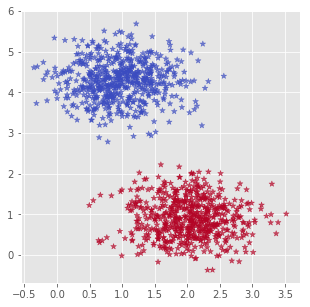

In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 5
plt.scatter(X_1[:, 0], X_1[:, 1], c = y_1, marker = '*', alpha = 0.7, cmap=plt.cm.coolwarm)

In [5]:
X_2, y_2 = make_blobs(n_samples=1200, centers=2, n_features=2, cluster_std = 2, random_state=0)

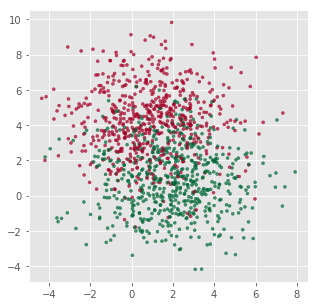

In [6]:
plt.scatter(X_2[:, 0], X_2[:, 1], c = y_2, marker = '.', alpha = 0.7, cmap=plt.cm.RdYlGn)

In [7]:
X_3, y_3 = datasets.make_circles(n_samples=1200, shuffle=True, noise=0.075, random_state=None, factor=0.5)

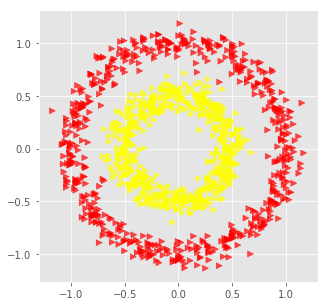

In [8]:
plt.scatter(X_3[:, 0], X_3[:, 1], c = y_3, marker = '>', alpha = 0.7, cmap=plt.cm.autumn)

Рассмотрим(https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture13-features.pdf) двойственную задачу метода опорных векторов:
$$\begin{cases}
\sum_{i=1}^l \lambda_i - \frac{1}{2} \sum_{i, \, j =1}^l \lambda_i \lambda_j y_i y_j \langle x_i, x_j\rangle \to \max_\lambda,\\
0 \le \lambda_i \le C, i = \overline{1, l},\\
\sum_{i=1}^l \lambda_i y_i = 0.
\end{cases}$$

После решения данной задачи прогнозы для новых объектов строятся следующим образом: $a(x) = \text{sign} \left( \sum_{i=1}^l \lambda_i y_i \langle x_i, x \rangle + b \right).$

Заметим, что и оптимизационная задача, и формула итогового классификатора зависят лишь от скалярных произведений объектов, а потому в данном методе можно использовать ядра для восстановления нелинейных зависимостей.

**2. (1.5 балла)** Обучите на сгенерированных ранее двумерных выборках [ядровой SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) с использованием следующих типов ядер (для различных значений гиперпараметра $C$):
- линейное: $K(x, z) = \langle x, z \rangle$;
- полиномиальное: $K(x, z) = (\gamma \langle x, z \rangle + 1)^d$ (для различных значений $\gamma, d$);
- гауссовское: $K(x, z) = \exp(-\gamma \|x - z\|^2)$ (для различных значений $\gamma$).

Визуализируйте разделяющую поверхность и разделяющую полосу:
 - для модели с линейным ядром для различных значений $C$;
 - для моделей, использующих полиномиальное и гауссовское ядро, соответствующих недообучению, нормальному поведению и переобучению.

In [10]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

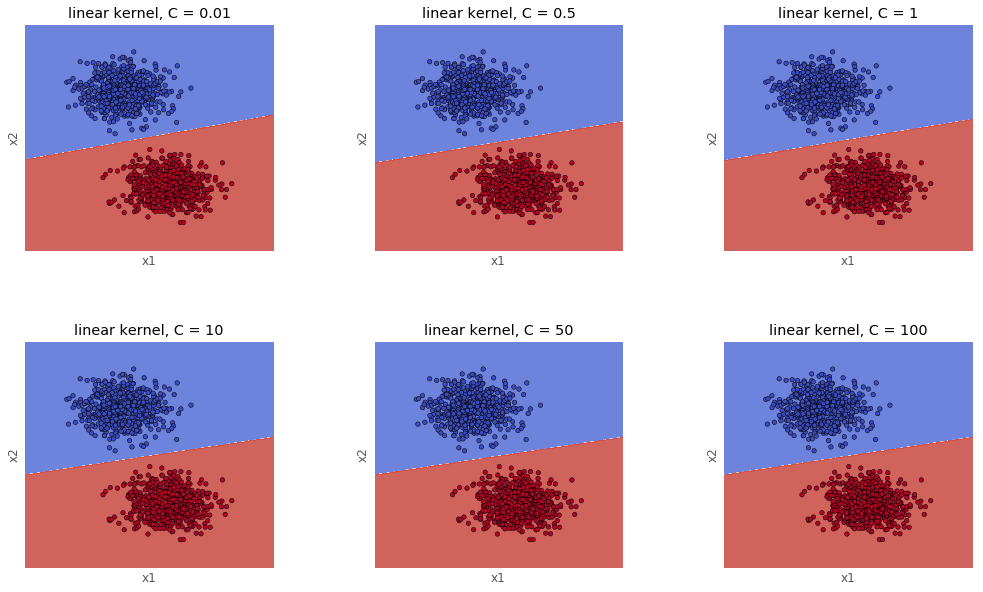

In [10]:
models = (SVC(kernel='linear', C = 0.01),
          SVC(kernel = 'linear', C = 0.5),
          SVC(kernel='linear', C = 1),
          SVC(kernel='linear', C = 10),
          SVC(kernel='linear', C = 50),
          SVC(kernel='linear', C = 100))
models = (clf.fit(X_1, y_1) for clf in models)


titles = ('linear kernel, C = 0.01',
          'linear kernel, C = 0.5',
          'linear kernel, C = 1',
          'linear kernel, C = 10', 
          'linear kernel, C = 50',
          'linear kernel, C = 100')


fig, sub = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


X0, X1 = X_1[:, 0], X_1[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_1, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 10
plt.show()

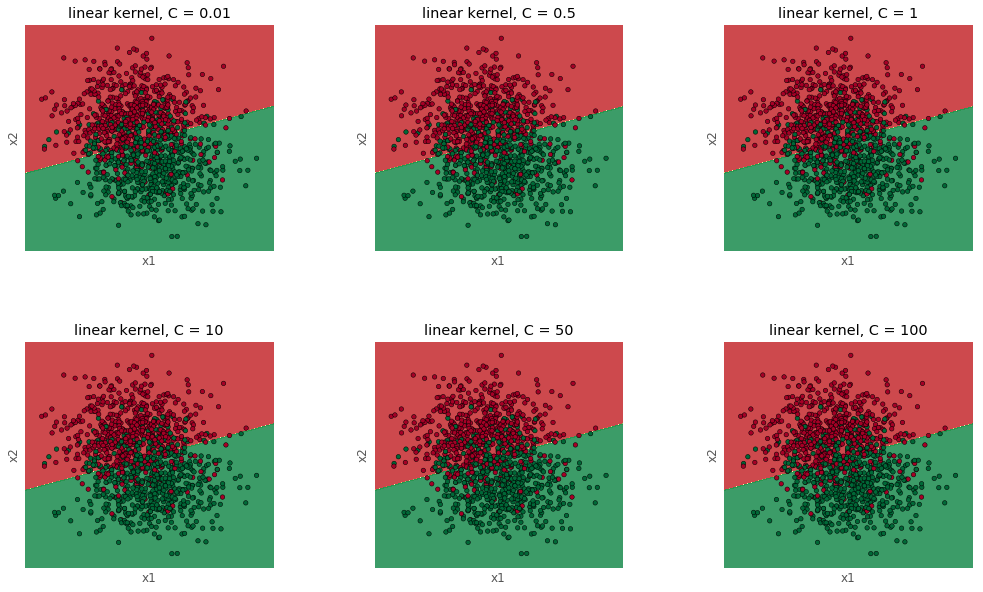

In [11]:
models = (SVC(kernel='linear', C = 0.01),
          SVC(kernel = 'linear', C = 0.5),
          SVC(kernel='linear', C = 1),
          SVC(kernel='linear', C = 10),
          SVC(kernel='linear', C = 50),
          SVC(kernel='linear', C = 100))
models = (clf.fit(X_2, y_2) for clf in models)


titles = ('linear kernel, C = 0.01',
          'linear kernel, C = 0.5',
          'linear kernel, C = 1',
          'linear kernel, C = 10', 
          'linear kernel, C = 50',
          'linear kernel, C = 100')


fig, sub = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


X0, X1 = X_2[:, 0], X_2[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.RdYlGn, alpha=0.8)
    ax.scatter(X0, X1, c=y_2, cmap=plt.cm.RdYlGn, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 10
plt.show()

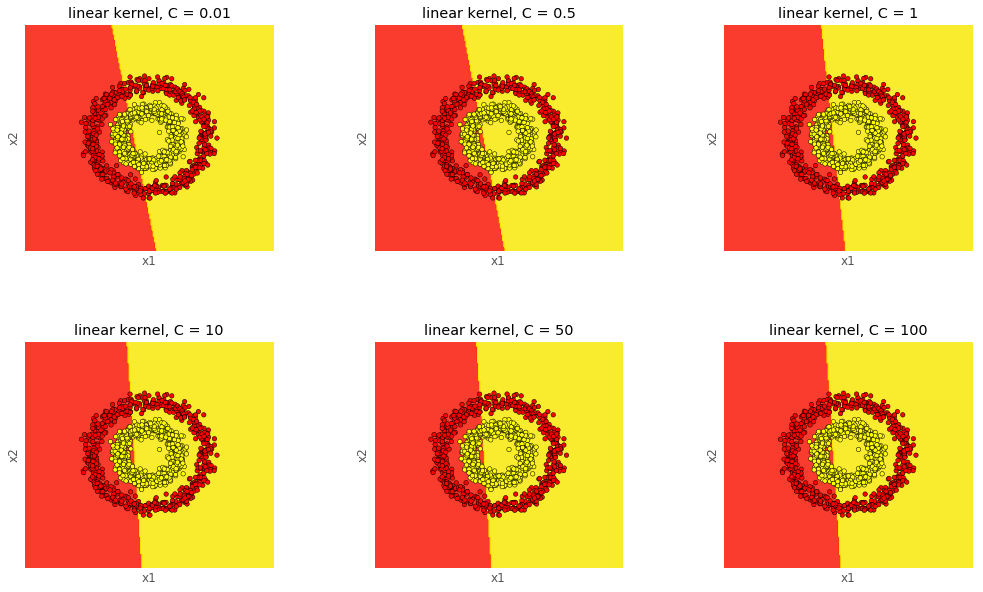

In [12]:
models = (SVC(kernel='linear', C = 0.01),
          SVC(kernel = 'linear', C = 0.5),
          SVC(kernel='linear', C = 1),
          SVC(kernel='linear', C = 10),
          SVC(kernel='linear', C = 50),
          SVC(kernel='linear', C = 100))
models = (clf.fit(X_3, y_3) for clf in models)

titles = ('linear kernel, C = 0.01',
          'linear kernel, C = 0.5',
          'linear kernel, C = 1',
          'linear kernel, C = 10', 
          'linear kernel, C = 50',
          'linear kernel, C = 100')

fig, sub = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


X0, X1 = X_3[:, 0], X_3[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.autumn, alpha=0.8)
    ax.scatter(X0, X1, c=y_3, cmap=plt.cm.autumn, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 10
plt.show()

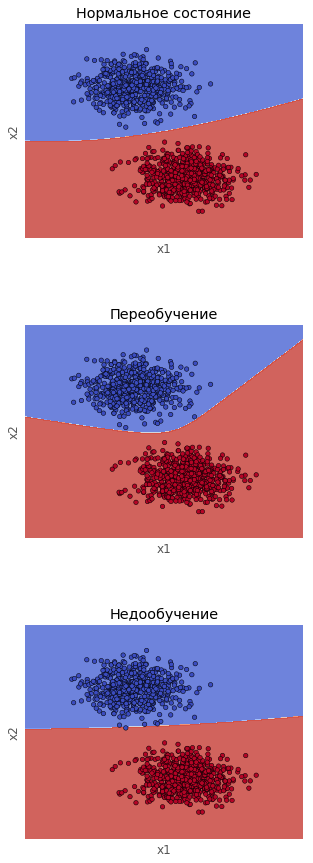

In [13]:
models = (SVC(kernel='poly', gamma = 1, degree = 2, coef0 = 1, C = 1),
          SVC(kernel='poly', gamma = 50, degree = 13, coef0 = 1, C = 100),
          SVC(kernel='poly', gamma = 0.01, degree = 11, coef0 = 1, C = 0.01))          
models = (clf.fit(X_1, y_1) for clf in models)


titles = ('Нормальное состояние',
          'Переобучение',
          'Недообучение')


fig, sub = plt.subplots(3, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


X0, X1 = X_1[:, 0], X_1[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_1, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 15
plt.show()

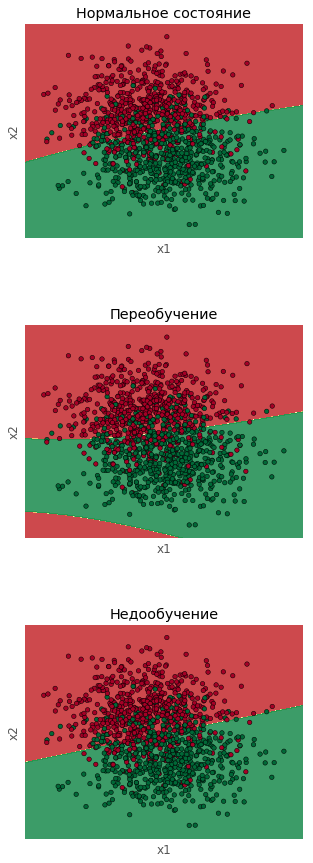

In [13]:
models = (SVC(kernel='poly', gamma = 0.1, degree = 2, coef0 = 1, C = 0.1),
          SVC(kernel='poly', gamma = 5, degree = 2, coef0 = 1, C = 200),
          SVC(kernel='poly', gamma = 0.0001, degree = 2, coef0 = 1, C = 0.0001))          
models = (clf.fit(X_2, y_2) for clf in models)


titles = ('Нормальное состояние',
          'Переобучение',
          'Недообучение')


fig, sub = plt.subplots(3, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


X0, X1 = X_2[:, 0], X_2[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.RdYlGn, alpha=0.8)
    ax.scatter(X0, X1, c=y_2, cmap=plt.cm.RdYlGn, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 15
plt.show()

При значениях degree выше 2 компьютер очень долго считал, поэтому для данной выборки используется только степень, равная двум. 

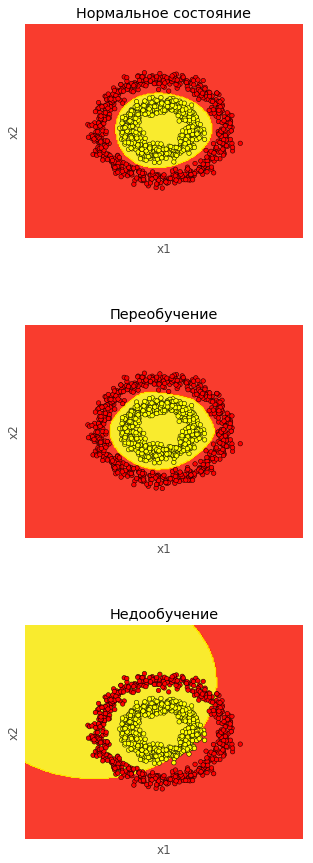

In [19]:
models = (SVC(kernel='poly', gamma = 10, degree = 3, coef0 = 1, C = 1),
          SVC(kernel='poly', gamma = 50, degree = 7, coef0 = 1, C = 100),
          SVC(kernel='poly', gamma = 0.01, degree = 2, coef0 = 1, C = 0.01))          
models = (clf.fit(X_3, y_3) for clf in models)


titles = ('Нормальное состояние',
          'Переобучение',
          'Недообучение')


fig, sub = plt.subplots(3, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


X0, X1 = X_3[:, 0], X_3[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.autumn, alpha=0.8)
    ax.scatter(X0, X1, c=y_3, cmap=plt.cm.autumn, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 15
plt.show()

В данном случае переобучение заключается в том, что граница классификатора строится прямо по красным точкам. Следовательно, если у нас будет выборка, где красная точка окажется ближе к центру, классификатор может допустить ошибку. 

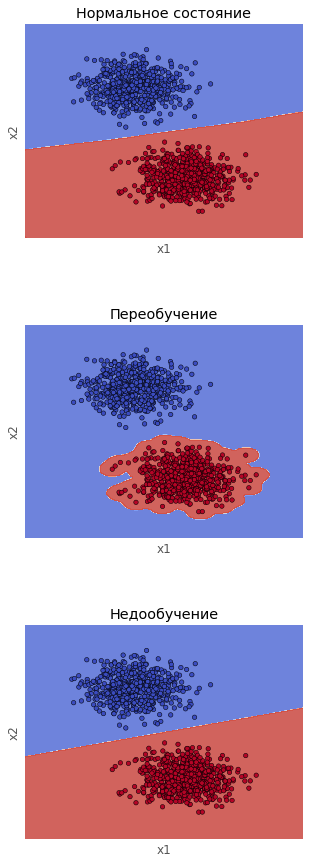

In [10]:
models = (SVC(kernel='rbf', gamma = 1, C = 0.1),
          SVC(kernel='rbf', gamma = 50, C = 100),
          SVC(kernel='rbf', gamma = 0.00000001, C = 0.0000001))          
models = (clf.fit(X_1, y_1) for clf in models)


titles = ('Нормальное состояние',
          'Переобучение',
          'Недообучение')


fig, sub = plt.subplots(3, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


X0, X1 = X_1[:, 0], X_1[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_1, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 15
plt.show()

Тщательный перебор параметров не дал возможности изобразить недообучение. 

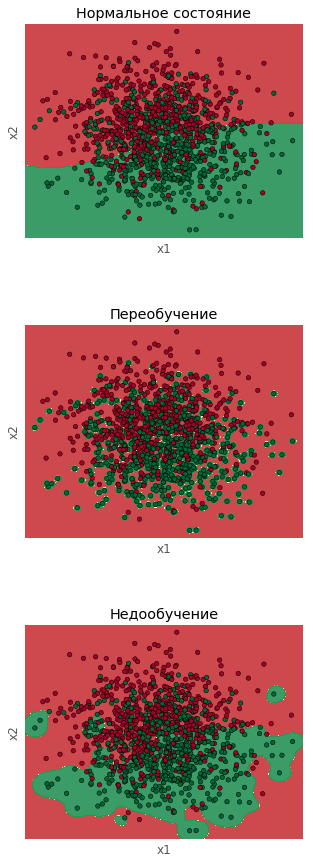

In [30]:
models = (SVC(kernel='rbf', gamma = 0.05, C = 1),
          SVC(kernel='rbf', gamma = 50, C = 1),
          SVC(kernel='rbf', gamma = 1, C = 0.1))          
models = (clf.fit(X_2, y_2) for clf in models)


titles = ('Нормальное состояние',
          'Переобучение',
          'Недообучение')

fig, sub = plt.subplots(3, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


X0, X1 = X_2[:, 0], X_2[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.RdYlGn, alpha=0.8)
    ax.scatter(X0, X1, c=y_2, cmap=plt.cm.RdYlGn, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 15
plt.show()

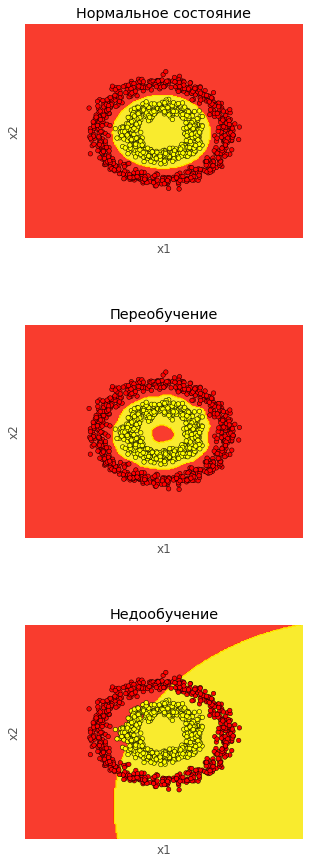

In [31]:
models = (SVC(kernel='rbf', gamma = 1, C = 1),
          SVC(kernel='rbf', gamma = 50, C = 1),
          SVC(kernel='rbf', gamma = 0.001, C = 1))          
models = (clf.fit(X_3, y_3) for clf in models)


titles = ('Нормальное состояние',
          'Переобучение',
          'Недообучение')

fig, sub = plt.subplots(3, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


X0, X1 = X_3[:, 0], X_3[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.autumn, alpha=0.8)
    ax.scatter(X0, X1, c=y_3, cmap=plt.cm.autumn, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 15
plt.show()

**3. (1 балл)** Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от значений гиперпараметра $C$, степени ядра $d$ и параметра $\gamma$?
 - Как ведет себя SVM с гауссовским ядром в зависимости от значений гиперпараметра $C$ и $\gamma$?

**Ответ:**

#### Полинимиальное ядро

- Увеличение параметра $C$ ведет к усилению подстройки под обучающую выборку. Соответственно чем меньше параметр C, тем больше вероятность недообучения. 

- Параметр $\gamma$ отвечает за симметричность рассматриваемого разделения. Соответственно чем он больше, тем более симметричным будет разбиение на классы. Поэтому его увлечение ведет к улучшению результатов на линейно-неразделимых выборках. Однако высокое значение данного параметра может стать причиной переобучения. 

- Гиперпараметр $d$ отвечает за степень и позволяет расширять поле используемых признаков. Что позволяет преобразовать нашу плоскость в линейно-разделимую, если разбиение классы определяется правилом, которое может быть получено с помощью возведения имеющихся признаков в некоторую степень. Следовательно, увелечение данного параметра позволяет получить кривую, которая задается многочленом степени, равной значению $d$. Кроме того, большие значения $d$ могут стать причиной переобучения.

#### Гауссовское ядро

- В целом для параметра $C$ в данном случае объяснение будет аналогичным тому, что было дано раннее. Чем выше значение данного гиперпараметра, тем больше мы подстраиваемся под обучающую выборку. При низких значениях данного параметра разделяющая поверхность будет более гладкой.  

- Для параметра $\gamma$ может быть использовано следующее объяснение. Данный параметр показывает насколько мы подстраиваемся под нашу обучающую выборку. Чем он выше, тем больше подстройка. Это отчетливо видно на всех картинках, так как при высоких значениях этого параметра мы сталкиваемся с проблемой переобучения, когда при разбиении на классы начинают обводиться конкретные точки. Чем он выше, тем менее симметричным будет разбиение. 

**4. (1.5 балл)** Обучите модели с использованием ядер из п. 2 для задачи бинарной классификации [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (используйте файл train.csv) для значения $C=1.$ Для оценки качества разбейте выборку на обучающую и тестовую в отношении 50/50. Постройте модель, позволяющую достичь значения accuracy, равного 0.75, на тестовой выборке. Позволяет ли использование ядер достичь лучшего качества по сравнению с линейной моделью?

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [49]:
df = pd.read_csv('train.csv')

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], test_size = 0.5, random_state = 12)

In [51]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'gamma':[0.01, 1, 10], 'degree':[2, 3], 'coef0':[1, 100, 0]}
svc = SVC(C = 1, random_state = 12)
clf = GridSearchCV(svc, parameters, scoring = 'accuracy', random_state = 12)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=12, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf', 'poly'), 'gamma': [0.01, 1, 10], 'degree': [2, 3], 'coef0': [1, 100, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [52]:
clf.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0,
  decision_function_shape=None, degree=2, gamma=0.01, kernel='poly',
  max_iter=-1, probability=False, random_state=12, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
clf.best_score_

0.76746666666666663

In [54]:
y_pred = clf.predict(X_test)

In [55]:
accuracy_score(y_test, y_pred)

0.76385927505330486

In [57]:
clf1 = SVC(C = 1, kernel = 'linear', random_state = 12)
clf1.fit(X_train, y_train)
y_pred_0 = clf1.predict(X_test)
accuracy_score(y_test, y_pred_0)

0.72761194029850751

**Ответ: да, позволяет, так как результат с полиномиальным ядром дает лучший результат.**

## SVD

Скачайте картинку и положите в каталог рядом с ноутбуком:

In [14]:
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
import sys
%matplotlib inline

img = misc.imread(r'art.jpg')

Посмотрим на нее:

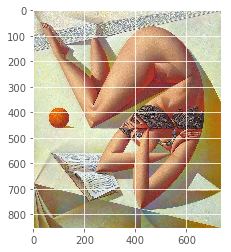

In [15]:
plt.imshow(img);

Для удобства оставим только один канал.

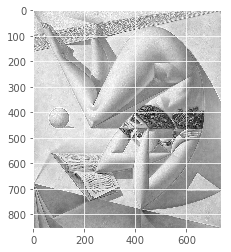

In [16]:
img = img[:,:,0]
plt.imshow(img, cmap='gray');

**5. (1 балла)** 

Главные компоненты - это матрицы вида  $u_i\sigma_iv_i^T$, где  $u_i, v_i$ это столбцы матриц $U$ и $V$ из сингулярного разложения; $\sigma_i$ соответсвующее сингулярное число. Визуализуйте первые и последние несколько компонент. Сделайте выводы.

In [17]:
from numpy.linalg import svd

In [18]:
U, s, V = svd(img)

In [19]:
S = np.zeros((len(U), len(V)))
S[:len(V), :len(V)] = np.diag(s)

In [20]:
def PCA_number(U, s, V, N):
    Jf = np.dot(U[:, N-1].reshape(-1, 1), np.dot(s[N-1, N-1], V[N-1, :].reshape(1, -1)))
    plt.imshow(Jf, cmap = 'gray')

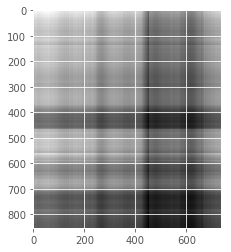

In [21]:
PCA_number(U, S, V, 1)

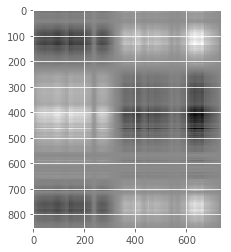

In [22]:
PCA_number(U, S, V, 2)

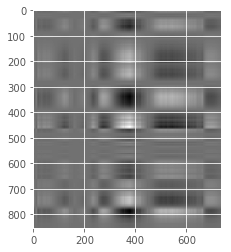

In [23]:
PCA_number(U, S, V, 3)

In [24]:
def PCA_number_last(U, s, V, N):
    Jf = np.dot(U[:, -(N+len(U)-len(V))].reshape(-1, 1), np.dot(s[-(N+len(U)-len(V)), -N], V[-N, :].reshape(1, -1)))
    plt.imshow(Jf, cmap = 'gray')

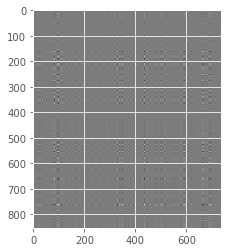

In [25]:
PCA_number_last(U, S, V, 1)

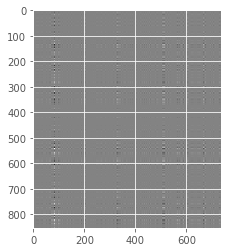

In [26]:
PCA_number_last(U, S, V, 2)

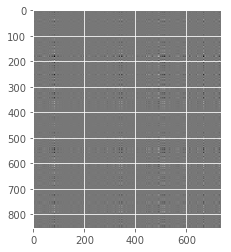

In [27]:
PCA_number_last(U, S, V, 3)

Посмотрим на первые несколько главных компонент. 

In [28]:
def PCA_first_N(U, s, V, N):
    Jf = np.dot(U[:, :N], np.dot(s[:N, :N], V[:N, :]))
    return Jf

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


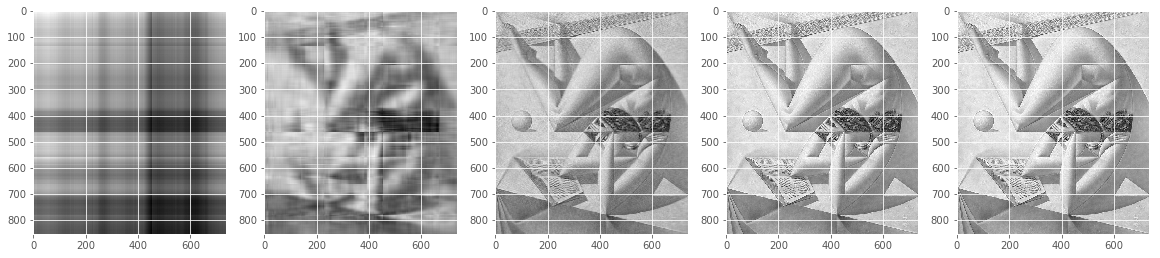

In [29]:
fig, axs = plt.subplots(1, 5)
fig.set_figheight(10)
fig.set_figwidth(20)

check_list = [1, 10, 100, 500, 700]
for i, ax in enumerate(axs.ravel()):
    Jf = PCA_first_N(U, S, V, check_list[i])
    ax.imshow(Jf, cmap = 'gray')
fig.show()

Посмотрим на последние компоненты: 

In [30]:
def PCA_last_N(U, s, V, N):
    Jf = np.dot(U[:, -(N+len(U)-len(V)):], np.dot(s[-(N+len(U)-len(V)):, -N:], V[-N:, :]))
    return Jf

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


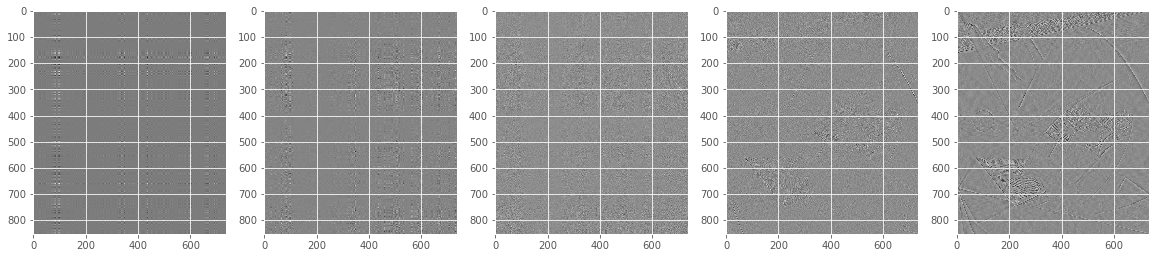

In [31]:
fig, axs = plt.subplots(1, 5)
fig.set_figheight(10)
fig.set_figwidth(20)

check_list = [1, 10, 100, 500, 700]
for i, ax in enumerate(axs.ravel()):
    Jf = PCA_last_N(U, S, V, check_list[i])
    ax.imshow(Jf, cmap = 'gray')
fig.show()

Можно сделать вывод, что первые главные компоненты отвечают за горизонтальную и вертикальную структуру, что отчетливо видно, если брать превые несколько главных компонент. Если их совместить, тогда получится размазанная картинка. Таким образом, последние компоненты отвечают за шум и очертания, которые достаточно трудно изобразить с помощью вертикальных и горизонтальных линий. Если посмотреть на компоненты с конца, будут видны очертания исходной картинки. 

**6. (1 балл)** 

Как вам кажется, сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения? Используйте график объясненной дисперсии для вашего выбора. Покажите полученные картинки для разного числа компонент.  Во сколько раз меньше памяти потребуется для хранения?  Вес объекта можно узнат командой * sys.getsizeof(x) *


In [32]:
sum(s)

485813.64068281412

In [33]:
var_val = []
a = 0
for i in range(len(s)):
    var_val.append((s[i] + a)/sum(s))
    a += s[i]

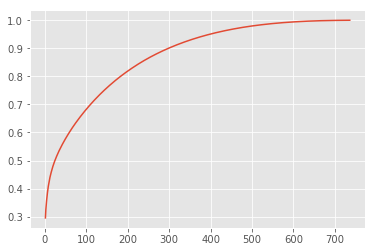

In [34]:
x_axis = np.arange(1, len(s)+1)
plt.plot(x_axis, var_val)

Для достаточно хорошего восстановления картинки будет достаточно взять 70 процентов объясненной дисперсии, те примерно 100 первых главных компонент.  

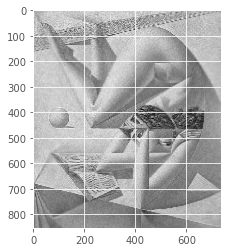

In [35]:
new_img = PCA_first_N(U, S, V, 100)
plt.imshow(new_img, cmap = 'gray')

In [41]:
old_size = sys.getsizeof(np.array(img, dtype = 'float32'))
old_size

2511344

In [47]:
new_size = sys.getsizeof(np.array(U[:, :100], dtype = 'float32')) + sys.getsizeof(np.array(S[:100, :100], dtype = 'float32')) + \
sys.getsizeof(np.array(V[:100, :], dtype = 'float32'))
new_size

341312

In [44]:
old_size/new_size

3.715357666998059

Для хранения понадобится примерно в 4 раза меньше памяти. 

## PCA

Рассмотрим нелиненый датасет. Попробуем решить задачу классификации, используя представление точек, полученнуе с помощью различных версий PCA.

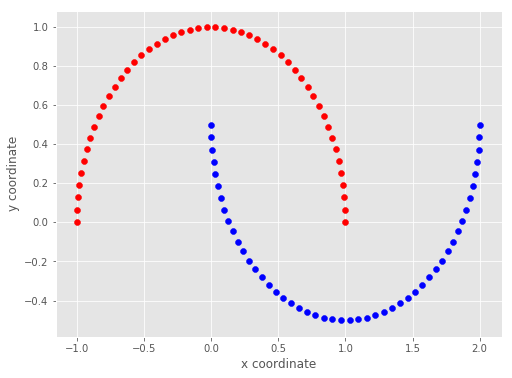

In [603]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=654)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

### Linear PCA

**7. (1 балл)** 

Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. 


In [634]:
from sklearn.decomposition import PCA
# Your code here
pca1 = PCA(n_components = 1)
pca1.fit(X, y)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [612]:
X_New = pca1.transform(X)

In [628]:
X_New = [X_New[y == 0], X_New[y == 1]]

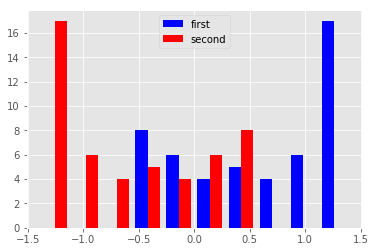

In [633]:
bins = 10

plt.hist(X_New, bins, color = ['blue', 'red'], label=['first', 'second'])
plt.legend()
plt.show()

In [635]:
pca2 = PCA(n_components = 2)
pca2.fit(X, y)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [636]:
X_New2 = pca2.transform(X)

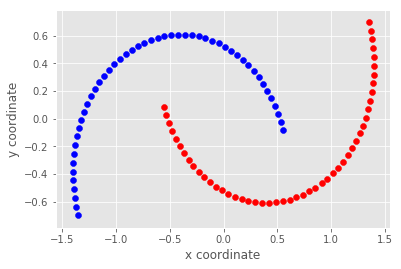

In [638]:
plt.scatter(X_New2[y==0, 0], X_New2[y==0, 1], color='red')
plt.scatter(X_New2[y==1, 0], X_New2[y==1, 1], color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

### RBF PCA

**8. (0.5 балла)** 
Допишите в месте "Your code here" построение матрицы Грамма для RBF ядра, с параметром gamma. Обратите внимание, что выше в коде уже получена матрица попарных расстояний sq_dists

In [641]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

In [642]:
def stepwise_kpca(X, gamma, n_components):
    """
    X: A MxN dataset as NumPy array where the samples are stored as rows (M), features as columns (N).
    gamma: coefficient for the RBF kernel.
    n_components: number of components to be returned.

    """
    # Calculating the squared Euclidean distances for every pair of points
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)

    K = exp(-gamma * mat_sq_dists)

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1, n_components+1)))

    return X_pc

**9. (2 балл)**  
Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. Подберите такой параметр gamma, что выборка стала линейно разделимой.

In [671]:
X_RBF2 = stepwise_kpca(X, 15, 2)

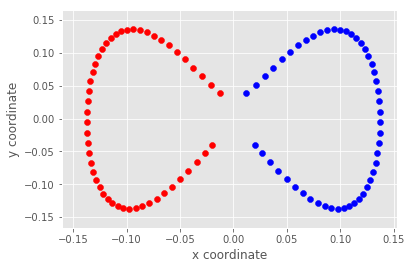

In [672]:
plt.scatter(X_RBF2[y==0, 0], X_RBF2[y==0, 1], color='red')
plt.scatter(X_RBF2[y==1, 0], X_RBF2[y==1, 1], color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

In [673]:
X_RBF1 = stepwise_kpca(X, 15, 1)

In [674]:
X_RBF1 = [X_RBF1[y == 0], X_RBF1[y == 1]]

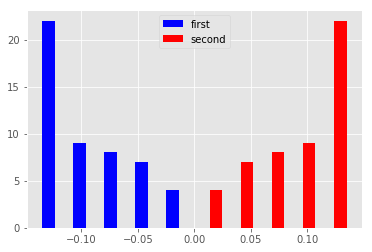

In [675]:
bins = 10

plt.hist(X_RBF1, bins, color = ['blue', 'red'], label=['first', 'second'])
plt.legend()
plt.show()

### Ваши мысли о задании:

Хотелось бы полегче задания

### Здесь можете поделиться картинкой

<img src="https://i.ytimg.com/vi/KEkrWRHCDQU/maxresdefault.jpg">